In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats
from scipy.interpolate import CubicSpline


from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec
from IPython.display import display, Math
from sklearn.metrics import r2_score

from statistics import mean, median
from pylr2 import regress2


In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

# convert columns to numeric data type
df_iron['FeT_Depth'] = pd.to_numeric(df_iron['FeT_Depth'], errors='coerce')
df_iron['Fe2_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].replace(0, np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].replace(0, np.nan)
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].replace(0, np.nan)


df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['NPOC_uM'] = df_doc['NPOC_uM'].replace(0, np.nan)
df_doc['TN_uM'] = df_doc['TN_uM'].replace(0, np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

df_doc = df_doc.drop(222101, axis=0)
df_doc = df_doc.drop(212211, axis=0)
df_doc = df_doc.drop(214311, axis=0)
df_doc = df_doc.drop(214317, axis=0)
df_doc = df_doc.drop(221710, axis=0)

In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

# Ensure that the indices are of the same type
df_c.index = df_c.index.astype(str)
df_meta.index = df_meta.index.astype(str)

# Concatenate the DataFrames
df_cdom = df_c.merge(df_meta, left_index=True, right_index=True)

In [6]:
df_spectra_pw = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)
df_spectra_rz = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_RZ.csv',sep=',', index_col=0)

df_spectra_pw.columns = ['a' + col for col in df_spectra_pw.columns]
df_spectra_rz.columns = ['a' + col for col in df_spectra_rz.columns]

df_spectra_pw.index = df_spectra_pw.index.astype(str)
df_spectra_rz.index = df_spectra_rz.index.astype(str)
df_meta.index = df_meta.index.astype(str)

df_spectra_pw = df_spectra_pw.merge(df_meta, left_index=True, right_index=True)
df_spectra_rz = df_spectra_rz.merge(df_meta, left_index=True, right_index=True)

df_spectra_pw['Sample_depth'] = pd.to_numeric(df_spectra_pw['Sample_depth'], errors='coerce')
df_spectra_rz['Sample_depth'] = pd.to_numeric(df_spectra_rz['Sample_depth'], errors='coerce')


In [7]:
#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.9_GOM2021"]
df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.5B_GOM2021"]
df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.4_GOM2021"]

df_doc_pw['Sample_ID'] = df_doc_pw.index
df_doc_pw.index = df_doc_pw['Sample_ID'] 

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

In [8]:
df_cdom_pw = df_spectra_pw[df_spectra_pw['Sample_depth'] != '-0.2' ]
df_cdom_rz = df_spectra_rz[df_spectra_rz['Sample_depth'] != '-0.2' ]

df_cdom_rz['Sample_depth'] = pd.to_numeric(df_cdom_rz['Sample_depth'], errors='coerce')
df_cdom_rz = df_cdom_rz.sort_values(by='Sample_depth')

df_iron_rz['FeT_Depth'] = pd.to_numeric(df_iron_rz['FeT_Depth'], errors='coerce')
df_iron_rz = df_iron_rz.sort_values(by='FeT_Depth')

#df_cdom_rz['code'] = df_cdom_rz['Station'] + '_' + df_cdom_rz['Campaign']
#df_cdom_rz['code'] = df_cdom_pw['Station'] + '_' + df_cdom_pw['Campaign']


C:\Users\hmlbr\AppData\Local\Temp\ipykernel_19896\819437245.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iron_rz['FeT_Depth'] = pd.to_numeric(df_iron_rz['FeT_Depth'], errors='coerce')


In [9]:
df_ncs = pd.read_csv('../Dissertation_projects/Data/CNS/NCS_data.csv',sep=',', index_col=0)

df_ncs['OC_gpcm3'] = df_ncs['OC_g/cm3'] 
df_ncs['N_gpcm3'] = df_ncs['N_g/cm3'] 
df_ncs['S_gpcm3'] = df_ncs['S_g/cm3'] 
df_ncs['C_gpcm3'] = df_ncs['C_g/cm3'] 


df_ncs['OC_mmolpcm3'] = df_ncs['OC_gpcm3'] / 12 * 1000
df_ncs['C_mmolpcm3'] = df_ncs['C_gpcm3'] / 12 * 1000
df_ncs['N_mmolpcm3'] = df_ncs['N_gpcm3'] / 14 * 1000
df_ncs['S_mmolpcm3'] = df_ncs['S_gpcm3'] / 32 * 1000


df_ncs['code'] = df_ncs['Station'] + '_' + df_ncs['Trip']

In [47]:
df_note = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/Station_summary.csv',sep=',', index_col=0)
df_note['Date'] = pd.to_datetime(df_note['date'])

In [11]:
# Get unique codes from df_doc_pw and df_cdom_pw
unique_codes_doc = np.sort(df_doc_pw['code'].unique())
unique_codes_cdom = np.sort(df_cdom_pw['code'].unique())
unique_codes_iron = np.sort(df_iron_pw['code'].unique())

# Concatenate unique codes
codes_list = np.concatenate((unique_codes_doc, unique_codes_cdom, unique_codes_iron))
codes_list = np.unique(codes_list)
print(len(codes_list))
print(codes_list)


44
['St.11_GOM2021' 'St.11_GOM21FA' 'St.11_GOM22SU' 'St.12_GOM21FA'
 'St.12_GOM22SU' 'St.13_GOM21FA' 'St.13_GOM22SP' 'St.13_GOM22SU'
 'St.14_GOM2021' 'St.14_GOM21FA' 'St.14_GOM22SP' 'St.14_GOM22SU'
 'St.15_GOM2021' 'St.15_GOM21FA' 'St.15_GOM22SP' 'St.15_GOM22SU'
 'St.16_GOM2021' 'St.16_GOM21FA' 'St.16_GOM22SP' 'St.16_GOM22SU'
 'St.2_GOM2021' 'St.2_GOM21FA' 'St.2_GOM22SP' 'St.2_GOM22SU'
 'St.4_GOM2021' 'St.4_GOM21FA' 'St.4_GOM22SP' 'St.4_GOM22SU'
 'St.5B_GOM2021' 'St.5B_GOM21FA' 'St.5B_GOM22SP' 'St.5B_GOM22SU'
 'St.7_GOM2021' 'St.7_GOM21FA' 'St.7_GOM22SP' 'St.7_GOM22SU'
 'St.9_GOM2021' 'St.9_GOM21FA' 'St.9_GOM22SP' 'St.9_GOM22SU'
 'St.MK_GOM2021' 'St.MK_GOM21FA' 'St.MK_GOM22SP' 'St.MK_GOM22SU']


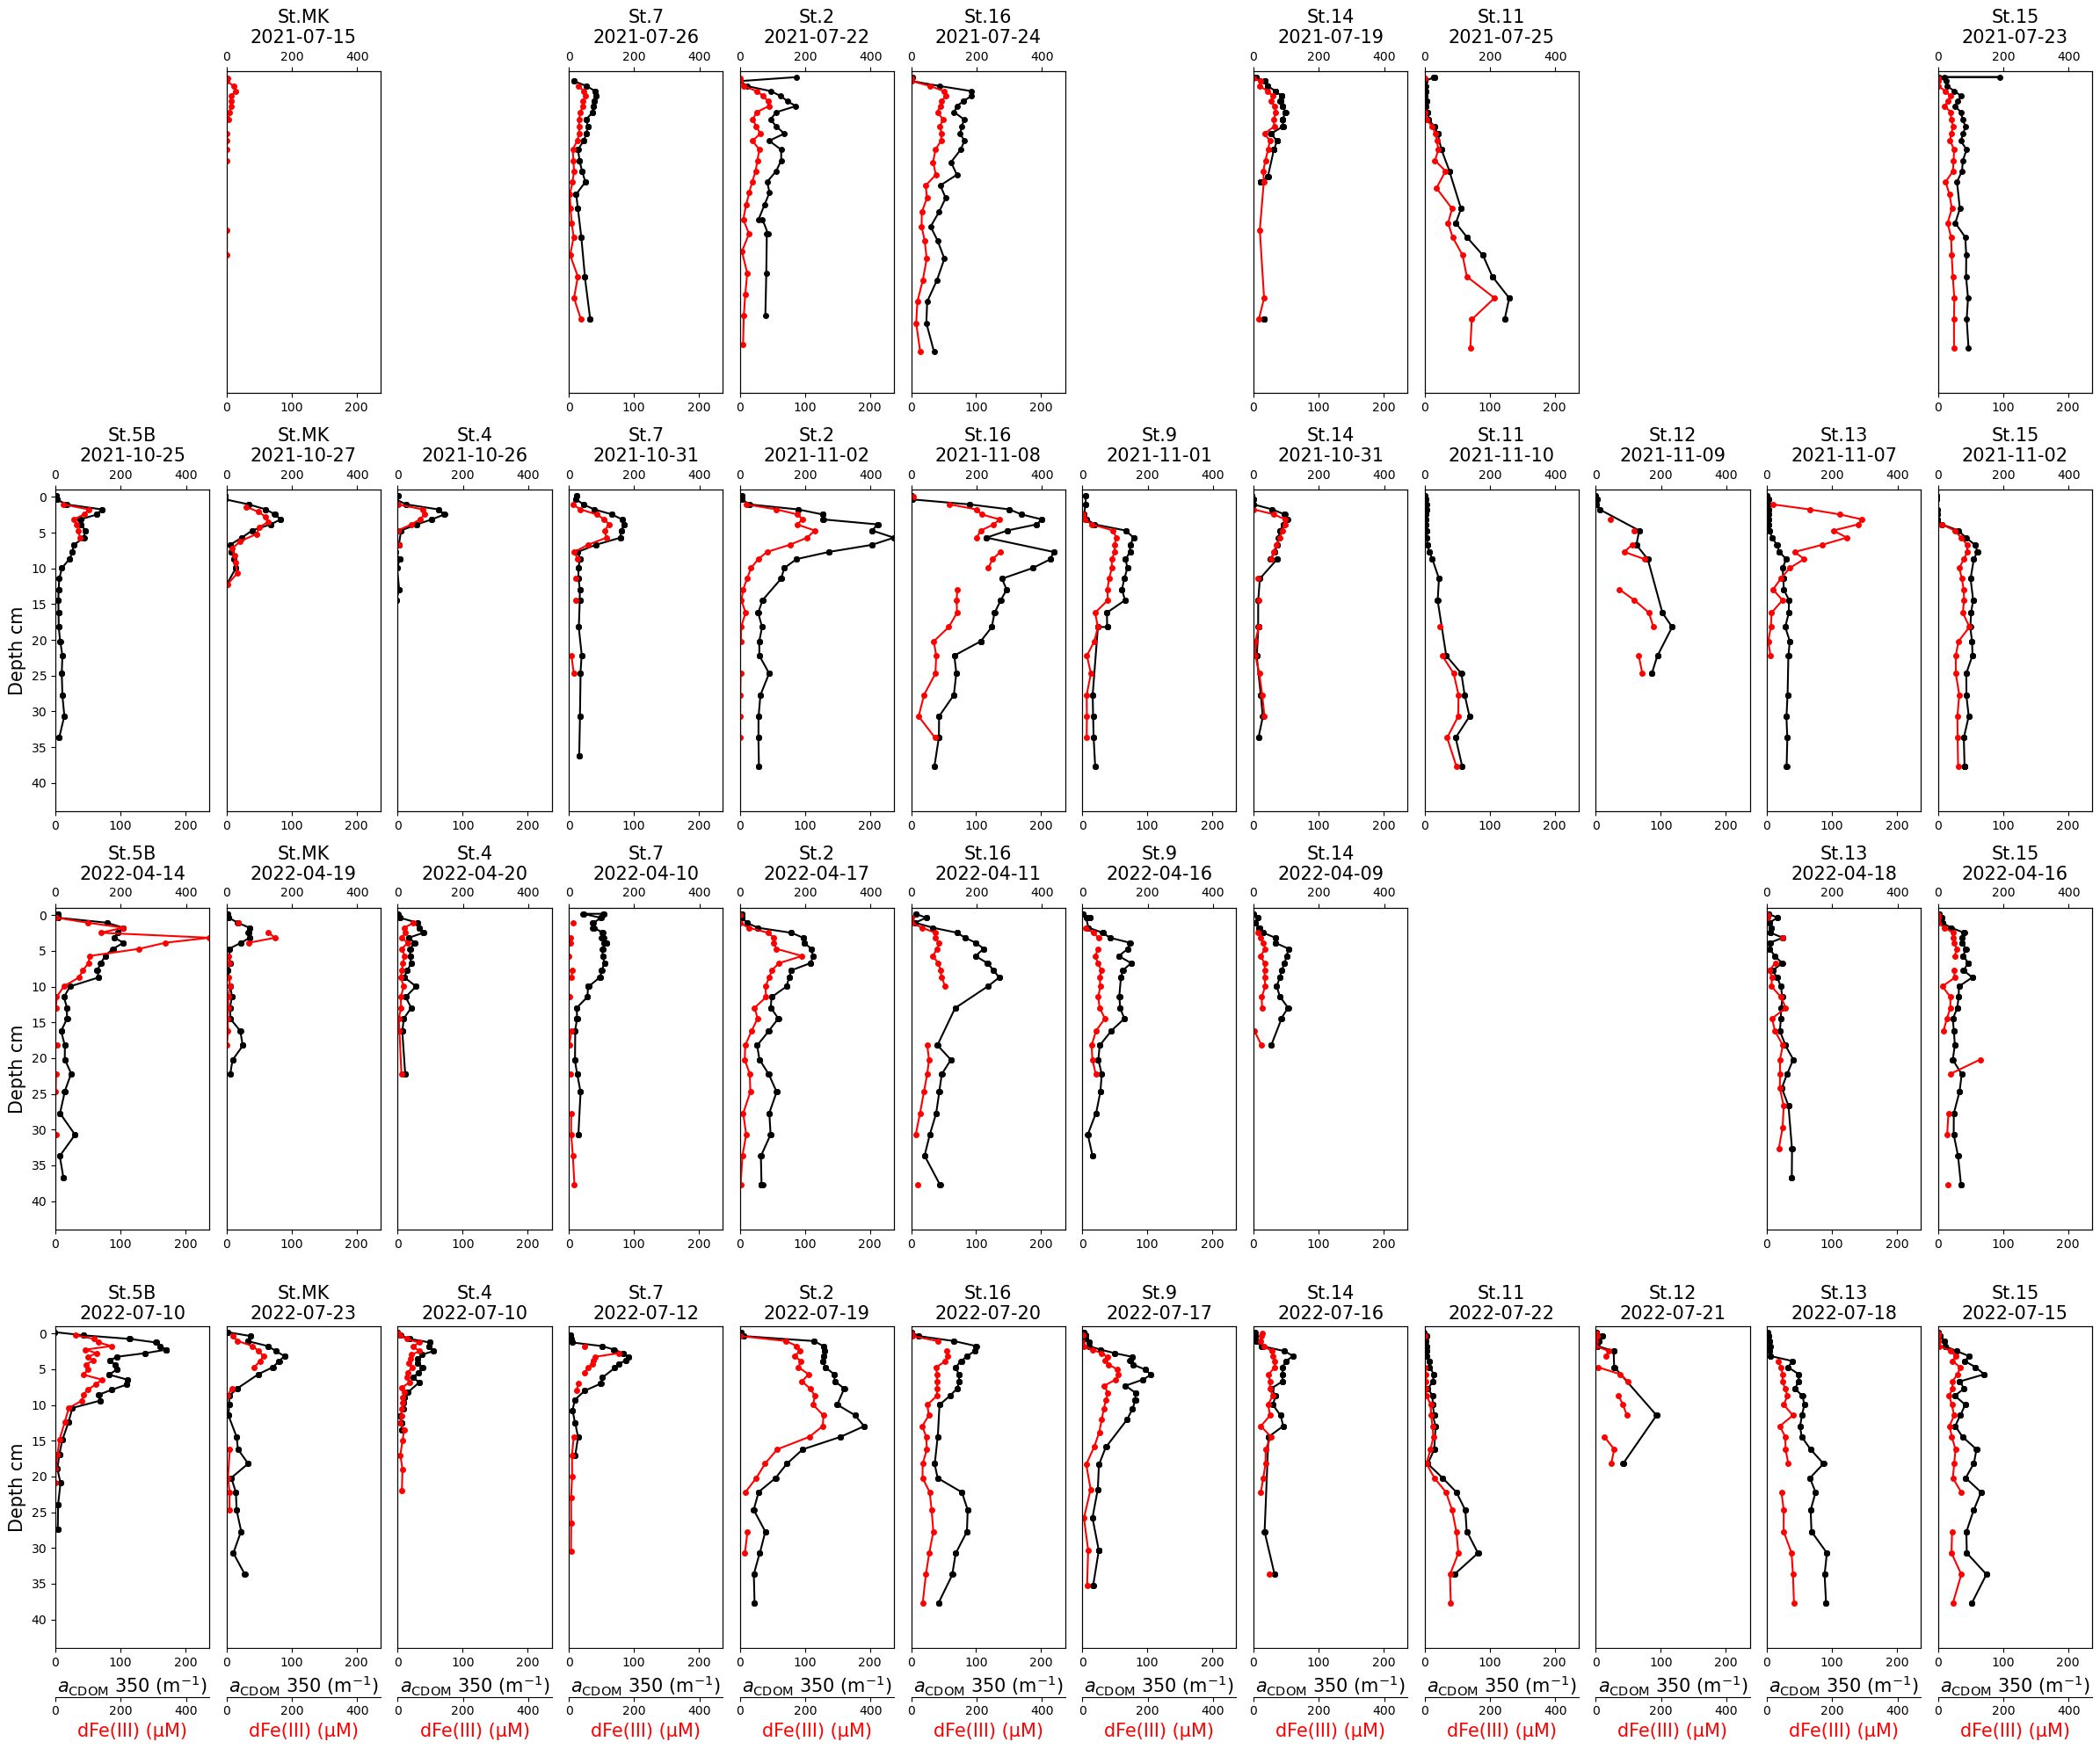

In [88]:
stations = ['St.5B', 'St.MK', 'St.4', 'St.7' ,'St.2', 'St.16', 'St.9', 'St.14', 'St.11', 'St.12', 'St.13', 'St.15']
trips = ['GOM2021','GOM21FA','GOM22SP', 'GOM22SU']

fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*5))

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        # Filter by trip and station
        #get data 
        data_iron_pw = df_iron_pw[(df_iron_pw['Campaign'] == trip) & (df_iron_pw['Location'] == station)]
        data_doc_pw = df_doc_pw[(df_doc_pw['Campaign'] == trip) & (df_doc_pw['Location'] == station)]
        data_doc_pw = data_doc_pw[data_doc_pw['NPOC_uM'] <= 2000]
        data_ncs = df_ncs[(df_ncs['Trip'] == trip) & (df_ncs['Station'] == station)]
        data_cdom_pw = df_cdom_pw[(df_cdom_pw['Trip'] == trip) & (df_cdom_pw['Station'] == station)]
    
        #For Pore Waters 
        #get vars DOC 
        doc_uM_pw = data_doc_pw['NPOC_uM'] 
        doc_uM_pw = np.asarray(doc_uM_pw, dtype=float).ravel()
        tn_uM_pw = data_doc_pw['TN_uM'] 
        tn_uM_pw = np.asarray(tn_uM_pw, dtype=float).ravel()
        doc_depth_pw = data_doc_pw['Depth'] #X var 
        doc_depth_pw = np.asarray(doc_depth_pw, dtype=float).ravel()

        #get vars Fe
        fe2_uM_pw = data_iron_pw['Fe2_uM'] 
        fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
        fe3_uM_pw = data_iron_pw['Fe3_uM'] 
        fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
        fe_depth_pw = data_iron_pw['FeT_Depth'] 
        fe_depth_pw = np.asarray(fe_depth_pw, dtype=float).ravel()
    
        #get vars OM
        a350 = data_cdom_pw['a350']
        a350 = np.asarray(a350, dtype=float).ravel()
        depth_cdom = data_cdom_pw['Sample_depth']
        depth_cdom = np.asarray(depth_cdom, dtype=float).ravel()
        
        if not data_doc_pw.empty:
            ax = axes[i, j]
            
            data_note = df_note[(df_note['camp'] == trip) & (df_note['station'] == station)]
            date_txt = pd.to_datetime(data_note['Date']).iloc[0].strftime('%Y-%m-%d')
            station = data_note['station'].iloc[0]
            rgn = data_note['rgn'].iloc[0]
            
            ax.plot(a350, depth_cdom, c = 'black', lw = 1.5,  marker = 'o', markersize = 4,  markeredgecolor='black')
            ax.set_title(f'{station}\n{date_txt}', size=15)
            ax.set_ylim(44, -1)
            ax.set_xlim(0, df_cdom_pw['a350'].max())
            
            ax4 = ax.twiny()
            ax4.plot(fe3_uM_pw, fe_depth_pw, c = 'red', lw = 1.5,  marker = 'o', markersize = 4,  markeredgecolor='red')
            ax4.set_ylim(44, -1)
            ax4.set_xlim(0, df_iron_pw['Fe3_uM'].max())
        
        else: 
            axes[i, j].axis('off')  
        if j == 0:
            axes[i,j].set_ylabel('Depth cm', size=15, c='black')
            axes[i,j].yaxis.set_tick_params(labelsize=10)
        else: 
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
            ax.set_yticks([])
        
        if i == 3:
            
            ax.set_xlabel(r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)', size = 15, c= 'black')
            ax.xaxis.set_tick_params(labelsize=10)
            
            ax4.set_xlabel('dFe(III) (\u03BCM)', size = 15, c= 'red')
            ax4.xaxis.set_tick_params(labelsize=10)
            ax4.xaxis.set_ticks_position('bottom')
            ax4.xaxis.set_label_position('bottom')
            ax4.spines['bottom'].set_position(('outward', 40))
            
            
plt.tight_layout()
fig.set_facecolor('w')
plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/Supplimnetal_profile_cdom_fe3_.png')
plt.show()

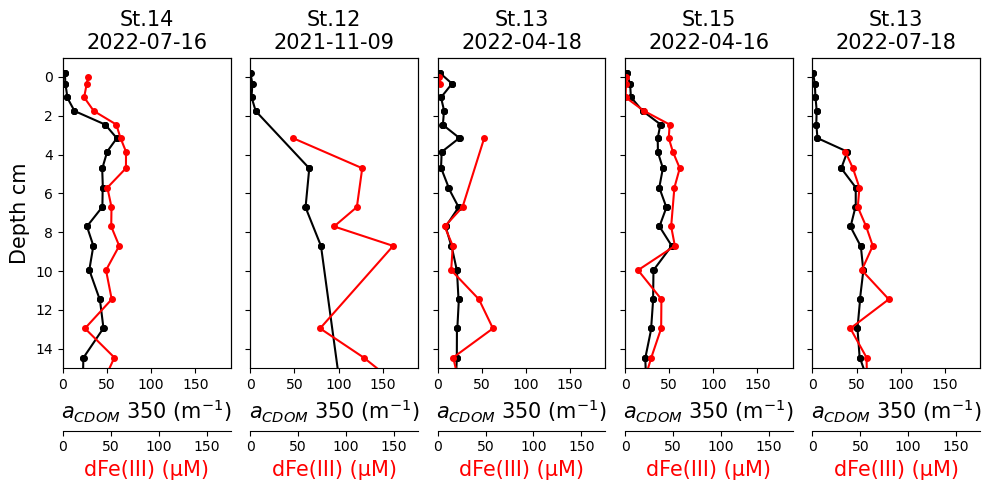

In [77]:
codes = [ 'St.16_GOM22SP', 'St.16_GOM22SU',
         'St.9_GOM22SP', 'St.14_GOM22SU', 'St.5B_GOM22SU',
         'St.MK_GOM22SP', 'St.MK_GOM22SU',
         'St.4_GOM22SP', 'St.4_GOM22SU',
         'St.7_GOM22SP','St.7_GOM22SU', 
         'St.12_GOM21FA', 'St.13_GOM22SP',
         'St.15_GOM22SP', 'St.13_GOM22SU']

codes = [ 'St.16_GOM22SP', 'St.16_GOM22SU','St.7_GOM22SP','St.7_GOM22SU','St.9_GOM22SP']

codes = ['St.5B_GOM22SU', 'St.MK_GOM22SP', 'St.MK_GOM22SU','St.4_GOM22SP', 'St.4_GOM22SU']

codes = ['St.14_GOM22SU', 'St.12_GOM21FA', 'St.13_GOM22SP', 'St.15_GOM22SP', 'St.13_GOM22SU']

fig, axes = plt.subplots(1, len(codes), figsize=(2*len(codes), 5))

for i, code in enumerate(codes):
    data_iron_pw = df_iron_pw[df_iron_pw['code'] == code]
    data_cdom_pw = df_cdom_pw[df_cdom_pw['code'] == code]
    data_iron_pw = data_iron_pw[data_iron_pw['Fe2_uM'] <= 400]

    data_note = df_note.loc[code]
    date_txt = pd.to_datetime(data_note['Date']).strftime('%Y-%m-%d')  # No need for `.iloc`
    station = data_note['station']
    ax = axes[i]
    
    # Get vars Fe
    fe2_uM_pw = data_iron_pw['Fe2_uM'] 
    fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
    fe3_uM_pw = data_iron_pw['Fe3_uM'] 
    fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
    fe_depth_pw = data_iron_pw['FeT_Depth'] 
    fe_depth_pw = np.asarray(fe_depth_pw, dtype=float).ravel()
    fe_depth_pw2 = data_iron_pw['Fe2_Depth'] 
    fe_depth_pw2 = np.asarray(fe_depth_pw2, dtype=float).ravel()
    
    # Get vars OM
    a350 = data_cdom_pw['a350']
    a350 = np.asarray(a350, dtype=float).ravel()
    depth_cdom = data_cdom_pw['Sample_depth']
    depth_cdom = np.asarray(depth_cdom, dtype=float).ravel()
        
    ax.plot(a350, depth_cdom, c = 'black', lw = 1.5,  marker = 'o', markersize = 4,  markeredgecolor='black')
    ax.set_title(f'{station}\n{date_txt}', size=15)
    ax.set_ylim(15, -1)
    ax.set_xlim(0, 190)
            
    ax3 = ax.twiny()
    ax3.plot(fe3_uM_pw, fe_depth_pw, c = 'red', lw = 1.5,  marker = 'o', markersize = 4,  markeredgecolor='red')
    ax3.set_xlim(0, 175)

    if i == 0: 
        ax.set_ylabel('Depth cm', size=15, c='black')
        ax.yaxis.set_tick_params(labelsize=10)
    else: 
        ax.set_ylabel('')
        ax.set_yticklabels([])
        
    ax.set_xlabel(r'$a_{CDOM}$ 350 (m$^{-1}$)', size=15, c='black')
    ax.xaxis.set_tick_params(labelsize=10)
            
    ax3.set_xlabel('dFe(III) (\u03BCM)', size=15, c='red')
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom') 
    ax3.spines['bottom'].set_position(('outward', 45))
            
plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Root_zone_profiles/profile_cdom_fe.png')
plt.show()


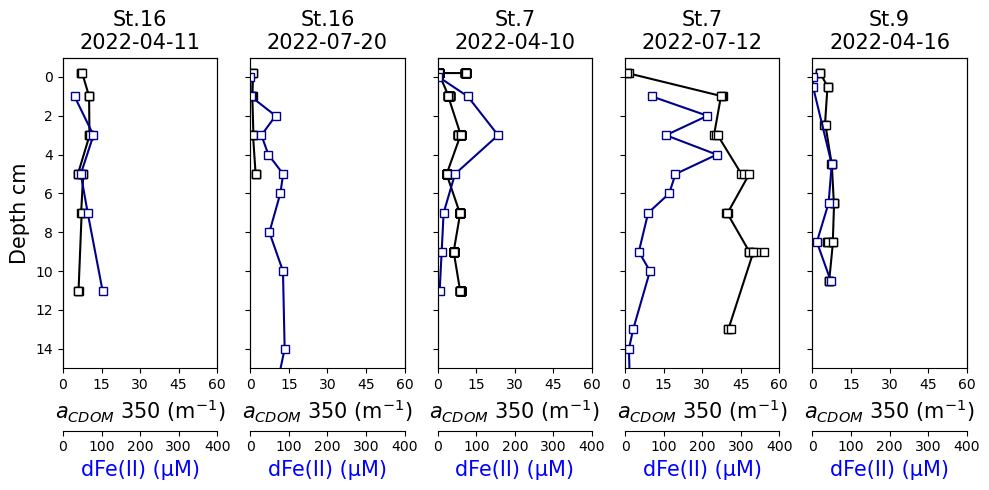

In [83]:
stations = ['St.2', 'St.16','St.5B', 'St.MK', 'St.4', 'St.7', 'St.9', 'St.14', 'St.11', 'St.12', 'St.13', 'St.15']
trips = ['GOM21FA','GOM22SP', 'GOM22SU']

codes = [ 'St.16_GOM22SP', 'St.16_GOM22SU',
         'St.9_GOM22SP', 'St.14_GOM22SU', 'St.5B_GOM22SU',
         'St.MK_GOM22SP', 'St.MK_GOM22SU',
         'St.4_GOM22SP', 'St.4_GOM22SU',
         'St.7_GOM22SP','St.7_GOM22SU', 
         'St.12_GOM21FA', 'St.13_GOM22SP',
         'St.15_GOM22SP', 'St.13_GOM22SU']

codes = [ 'St.16_GOM22SP', 'St.16_GOM22SU','St.7_GOM22SP','St.7_GOM22SU','St.9_GOM22SP']

#codes = ['St.5B_GOM22SU', 'St.MK_GOM22SP', 'St.MK_GOM22SU','St.4_GOM22SP', 'St.4_GOM22SU']

#codes = ['St.14_GOM22SU', 'St.12_GOM21FA', 'St.13_GOM22SP', 'St.15_GOM22SP', 'St.13_GOM22SU']

fig, axes = plt.subplots(1, len(codes), figsize=(2*len(codes), 5))
for i, code in enumerate(codes):
    data_iron_rz = df_iron_rz[df_iron_rz['code'] == code]
    data_cdom_rz = df_cdom_rz[df_cdom_rz['code'] == code]
    data_iron_rz = data_iron_rz[data_iron_rz['Fe2_uM'] <= 400]

    data_note = df_note.loc[code]
    date_txt = pd.to_datetime(data_note['Date']).strftime('%Y-%m-%d')  # No need for `.iloc`
    station = data_note['station']


    ax = axes[i]
    
    # Get vars Fe
    fe2_uM_rz = data_iron_rz['Fe2_uM'] 
    fe2_uM_rz = np.asarray(fe2_uM_rz, dtype=float).ravel()
    fe3_uM_rz = data_iron_rz['Fe3_uM'] 
    fe3_uM_rz = np.asarray(fe3_uM_rz, dtype=float).ravel()
    fe_depth_rz = data_iron_rz['FeT_Depth'] 
    fe_depth_rz = np.asarray(fe_depth_rz, dtype=float).ravel()
    fe_depth_rz2 = data_iron_rz['Fe2_Depth'] 
    fe_depth_rz2 = np.asarray(fe_depth_rz2, dtype=float).ravel()
    
    # Get vars OM
    a350 = data_cdom_rz['a350']
    a350 = np.asarray(a350, dtype=float).ravel()
    depth_cdom = data_cdom_rz['Sample_depth']
    depth_cdom = np.asarray(depth_cdom, dtype=float).ravel()
        
    ax.plot(a350, depth_cdom, c = 'black', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='black')
    ax.set_title(f'{station}\n{date_txt}', size=15)
    ax.set_ylim(15, -1)
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 15, 30, 45, 60])

        
    ax3 = ax.twiny()
    ax3.plot(fe2_uM_rz, fe_depth_rz2, c = 'darkblue', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkblue')
    ax3.set_xlim(0, 400)
    ax3.set_xticks([0, 100, 200, 300, 400])

    if i == 0: 
        ax.set_ylabel('Depth cm', size=15, c='black')
        ax.yaxis.set_tick_params(labelsize=10)
    else: 
        ax.set_ylabel('')
        ax.set_yticklabels([])
        
    ax.set_xlabel(r'$a_{CDOM}$ 350 (m$^{-1}$)', size=15, c='black')
    ax.xaxis.set_tick_params(labelsize=10)
            
    ax3.set_xlabel('dFe(II) (\u03BCM)', size=15, c='blue')
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom') 
    ax3.spines['bottom'].set_position(('outward', 45))
            
plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Root_zone_profiles/profile_cdom_fe.png')
plt.show()

In [79]:
df_cdom_rz['a350'].max()

57.88394494494071

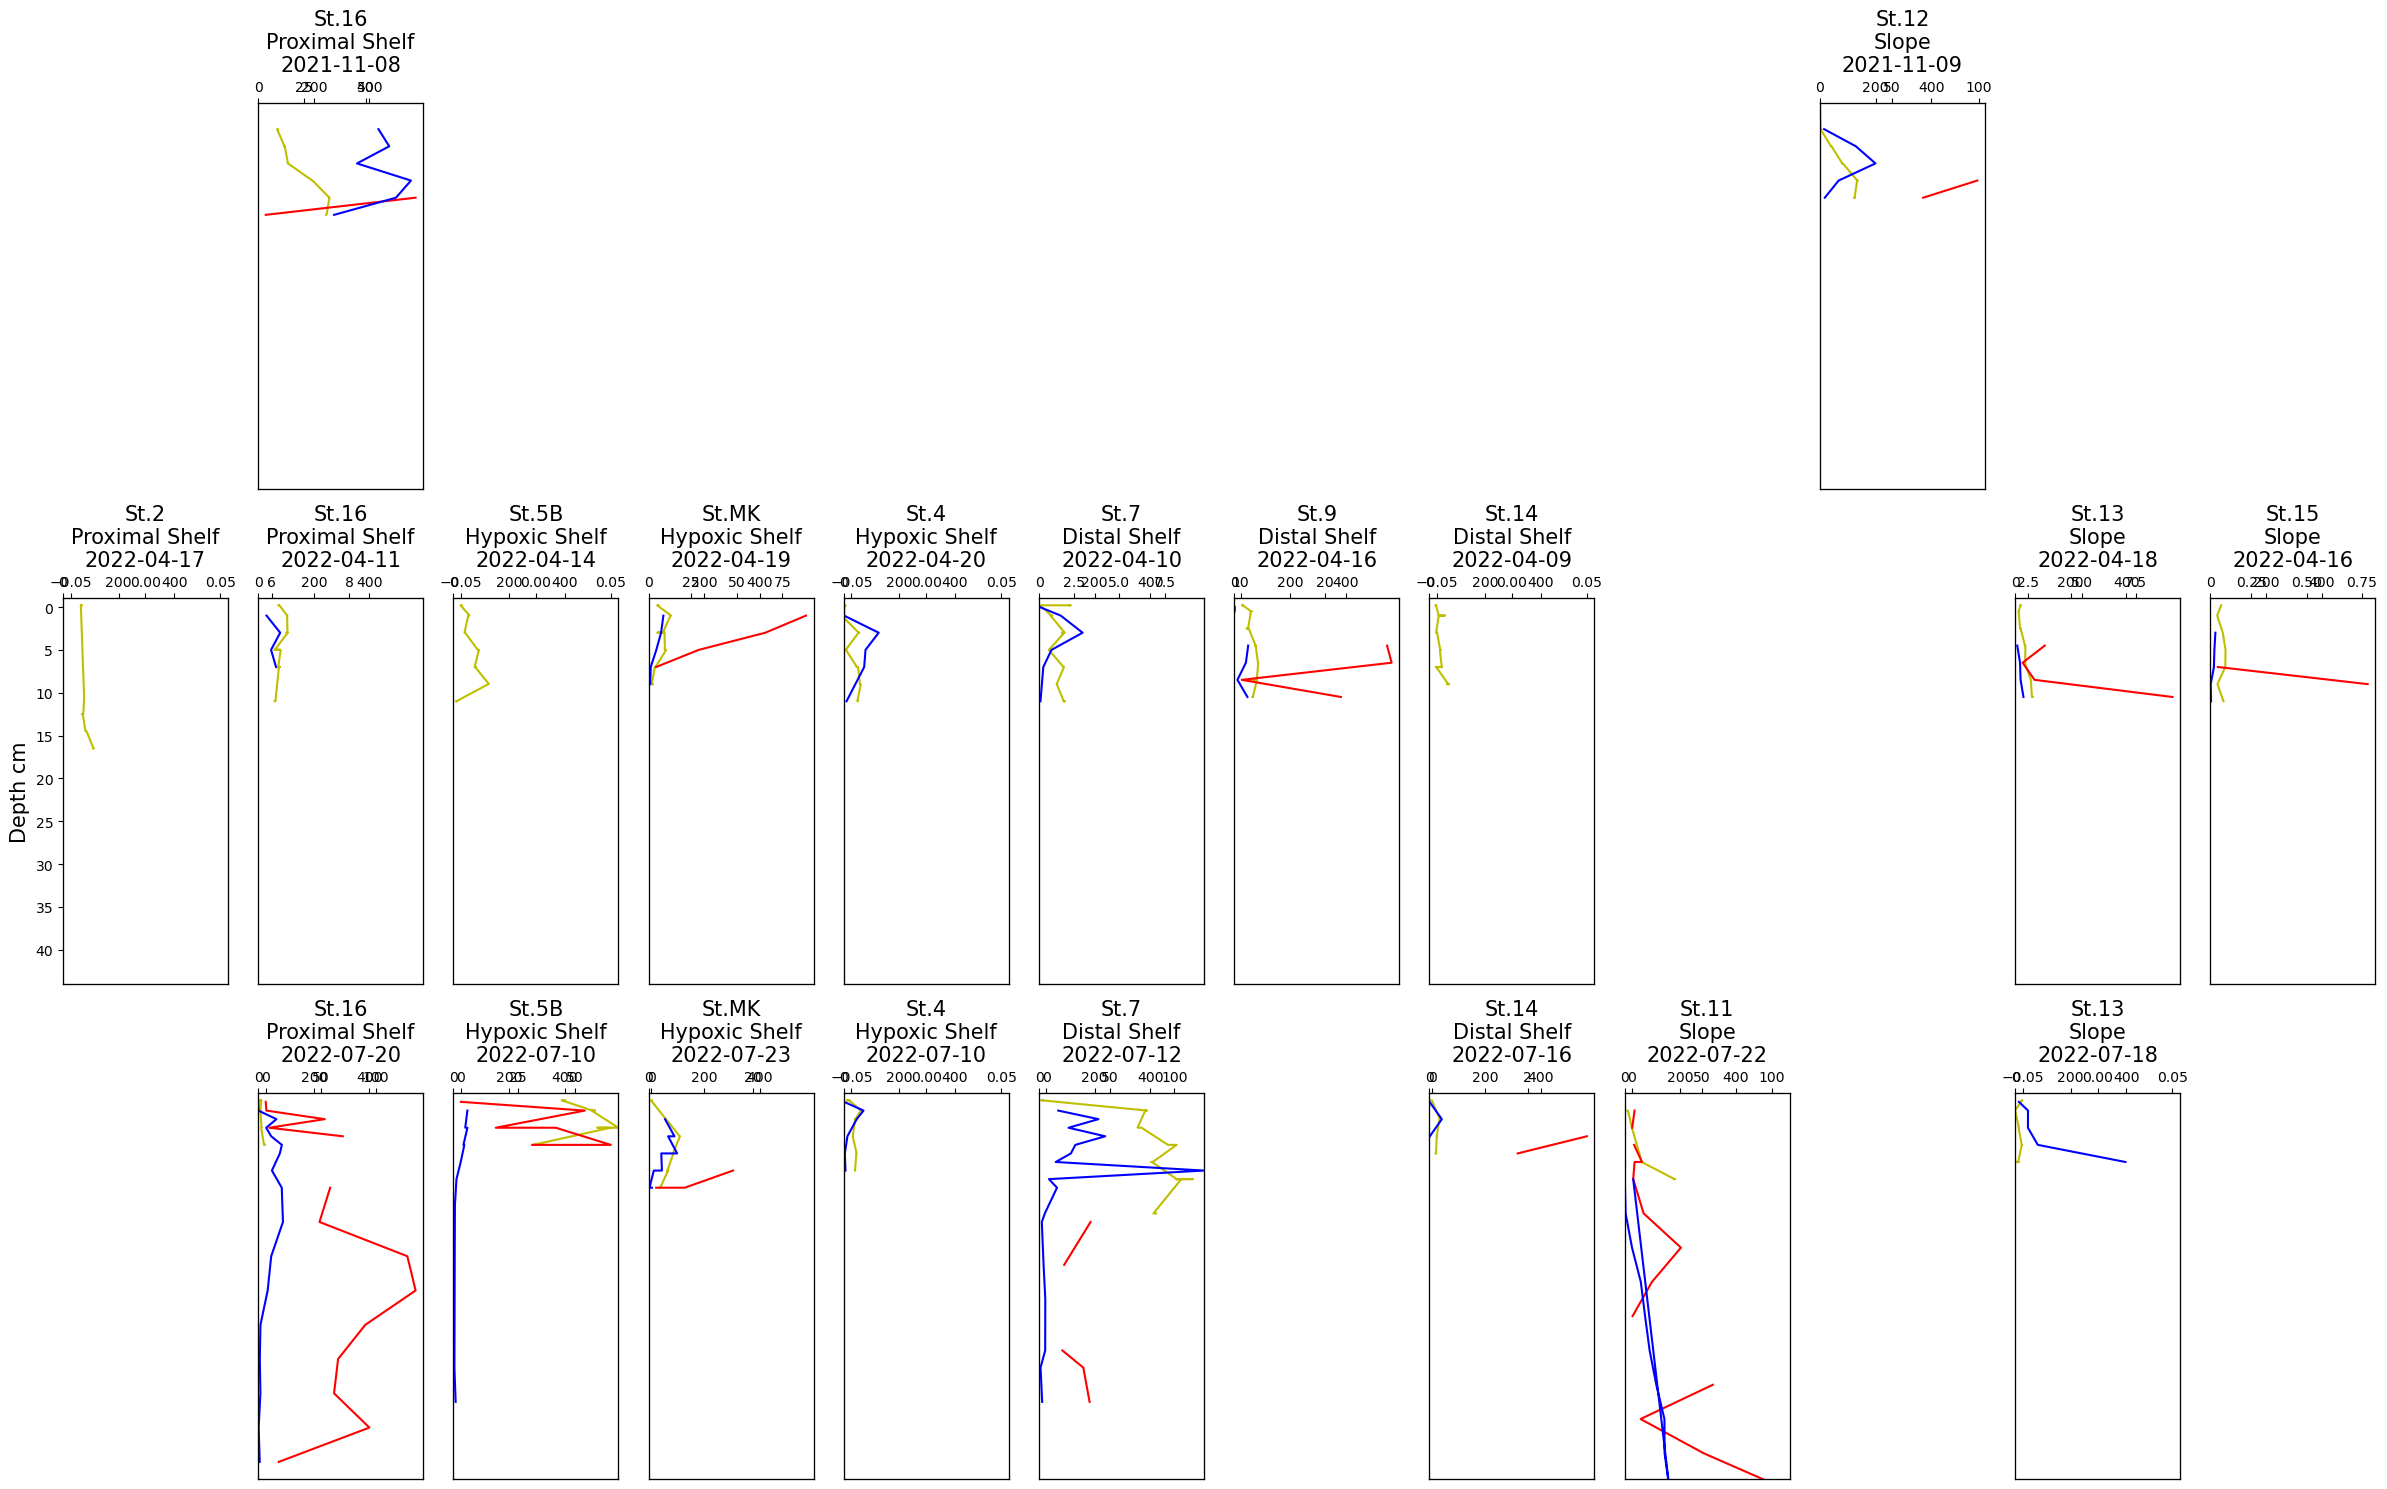

In [20]:
stations = ['St.2', 'St.16','St.5B', 'St.MK', 'St.4', 'St.7', 'St.9', 'St.14', 'St.11', 'St.12', 'St.13', 'St.15']
trips = ['GOM21FA','GOM22SP', 'GOM22SU']

fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*5))

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        # Filter by trip and station
        # Get data
        data_iron_rz = df_iron_rz[(df_iron_rz['Campaign'] == trip) & (df_iron_rz['Location'] == station)]

        data_doc_rz = df_doc_rz[(df_doc_rz['Campaign'] == trip) & (df_doc_rz['Location'] == station)]
        data_doc_rz = data_doc_rz[data_doc_rz['NPOC_uM'] <= 2000]

        data_cdom_rz = df_cdom_rz[(df_cdom_rz['Trip'] == trip) & (df_cdom_rz['Station'] == station)]

        data_ncs = df_ncs[(df_ncs['Trip'] == trip) & (df_ncs['Station'] == station)]

        # For Root Zone
        # Get vars DOC
        doc_uM_rz = data_doc_rz['NPOC_uM'] 
        doc_uM_rz = np.asarray(doc_uM_rz, dtype=float).ravel()
        tn_uM_rz = data_doc_rz['TN_uM'] 
        tn_uM_rz = np.asarray(tn_uM_rz, dtype=float).ravel()
        doc_depth_rz = data_doc_rz['Depth'] # X var
        doc_depth_rz = np.asarray(doc_depth_rz, dtype=float).ravel()

        # Get vars Fe
        fe2_uM_rz = data_iron_rz['Fe2_uM'] 
        fe2_uM_rz = np.asarray(fe2_uM_rz, dtype=float).ravel()
        fe3_uM_rz = data_iron_rz['Fe3_uM'] 
        fe3_uM_rz = np.asarray(fe3_uM_rz, dtype=float).ravel()
        fe_depth_rz = data_iron_rz['FeT_Depth'] 
        fe_depth_rz = np.asarray(fe_depth_rz, dtype=float).ravel()
        fe_depth_rz2 = data_iron_rz['Fe2_Depth'] 
        fe_depth_rz2 = np.asarray(fe_depth_rz2, dtype=float).ravel()
    
        # Get vars OM
        a350 = data_cdom_rz['a350']
        a350 = np.asarray(a350, dtype=float).ravel()
        depth_cdom = data_cdom_rz['Sample_depth']
        depth_cdom = np.asarray(depth_cdom, dtype=float).ravel()
        
        if not data_iron_rz.empty:
            ax = axes[i, j]
            
            data_note = df_note[(df_note['camp'] == trip) & (df_note['station'] == station)]
            date_txt = pd.to_datetime(data_note['Date']).iloc[0].strftime('%Y-%m-%d')
            station = data_note['station'].iloc[0]
            rgn = data_note['rgn'].iloc[0]
            
            ax.plot(a350, depth_cdom, c = 'y')
            ax.set_title(f'{station}\n{rgn}\n{date_txt}', size=15)
            ax.set_ylim(44, -1)
            ax.set_xlim(0, df_cdom_rz['a350'].max())
            
            ax4 = ax.twiny()
            ax4.plot(fe3_uM_rz, fe_depth_rz, c = 'red')
            #ax4.set_ylim(44, -1)
            #ax4.set_xlim(0, df_iron_rz['Fe3_uM'].max())

            ax3 = ax.twiny()
            ax3.plot(fe2_uM_rz, fe_depth_rz2, c = 'blue')
            ax3.set_ylim(44, -1)
            ax3.set_xlim(0, df_iron_rz['Fe2_uM'].max())
        
        else: 
            axes[i, j].axis('off')  
        if j == 0:
            axes[i,j].set_ylabel('Depth cm', size=15, c='black')
            axes[i,j].yaxis.set_tick_params(labelsize=10)
        else: 
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
            ax.set_yticks([])
        
        if i == 3:
            ax.set_xlabel(r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)', size=10, c='y')
            ax.xaxis.set_tick_params(labelsize=10)
            
            ax4.set_xlabel('dFe(II) (\u03BCM)', size=15, c='blue')
            ax4.xaxis.set_ticks_position('bottom')
            ax4.xaxis.set_label_position('bottom')
            ax4.spines['bottom'].set_position(('outward', 40))

            #ax3.set_xlabel('dFe(III) (\u03BCM)', size=15, c='red')
            #ax3.xaxis.set_ticks_position('bottom')
            #ax3.xaxis.set_label_position('bottom')
            #ax3.spines['bottom'].set_position(('outward', 80))
        else: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
            ax.set_xticks([])
            
plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Root_zone_profiles/profile_cdom_fe.png')
plt.show()


In [ ]:
stations = ['St.2', 'St.16','St.5B', 'St.MK', 'St.4', 'St.7', 'St.9', 'St.14', 'St.11', 'St.12', 'St.13', 'St.15']
trips = ['GOM2021','GOM21FA','GOM22SP', 'GOM22SU']

fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*5))

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        # Filter by trip and station
        #get data 
        data_iron_pw = df_iron_pw[(df_iron_pw['Campaign'] == trip) & (df_iron_pw['Location'] == station)]
        data_doc_pw = df_doc_pw[(df_doc_pw['Campaign'] == trip) & (df_doc_pw['Location'] == station)]
        data_doc_pw = data_doc_pw[data_doc_pw['NPOC_uM'] <= 2000]
        data_ncs = df_ncs[(df_ncs['Trip'] == trip) & (df_ncs['Station'] == station)]
        data_cdom_pw = df_cdom_pw[(df_cdom_pw['Trip'] == trip) & (df_cdom_pw['Station'] == station)]
    
        #For Pore Waters 
        #get vars DOC 
        doc_uM_pw = data_doc_pw['NPOC_uM'] 
        doc_uM_pw = np.asarray(doc_uM_pw, dtype=float).ravel()
        tn_uM_pw = data_doc_pw['TN_uM'] 
        tn_uM_pw = np.asarray(tn_uM_pw, dtype=float).ravel()
        doc_depth_pw = data_doc_pw['Depth'] #X var 
        doc_depth_pw = np.asarray(doc_depth_pw, dtype=float).ravel()

        #get vars Fe
        fe2_uM_pw = data_iron_pw['Fe2_uM'] 
        fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
        fe3_uM_pw = data_iron_pw['Fe3_uM'] 
        fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
        fe_depth_pw = data_iron_pw['Fe2_Depth'] 
        fe_depth_pw = np.asarray(fe_depth_pw, dtype=float).ravel()
    
        #get vars OM
        a350 = data_cdom_pw['a350']
        a350 = np.asarray(a350, dtype=float).ravel()
        depth_cdom = data_cdom_pw['Sample_depth']
        depth_cdom = np.asarray(depth_cdom, dtype=float).ravel()
        
        if not data_doc_pw.empty:
            ax = axes[i, j]
            
            data_note = df_note[(df_note['camp'] == trip) & (df_note['station'] == station)]
            date_txt = pd.to_datetime(data_note['Date']).iloc[0].strftime('%Y-%m-%d')
            station = data_note['station'].iloc[0]
            rgn = data_note['rgn'].iloc[0]
            
            ax.plot(doc_uM_pw, doc_depth_pw, c = 'black')
            ax.set_title(f'{station}\n{rgn}\n{date_txt}', size=15)
            ax.set_ylim(44, -1)
            ax.set_xlim(0, 2000)
            
            ax2 = ax.twiny()
            ax2.plot(a350, depth_cdom, c = 'y')
            ax.set_ylim(44, -1)
            ax2.set_xlim(0, 300)
            
            ax3 = ax.twiny()
            ax3.plot(fe2_uM_pw, fe_depth_pw, c = 'blue')
            ax3.set_ylim(44, -1)
            ax3.set_xlim(0, 300)
            
            ax4 = ax.twiny()
            ax4.plot(fe3_uM_pw, fe_depth_pw, c = 'red')
            ax4.set_ylim(44, -1)
            ax4.set_xlim(0, 300)
        
        else: 
            axes[i, j].axis('off')  
        if j == 0:
            axes[i,j].set_ylabel('Depth cm', size=15, c='black')
            axes[i,j].yaxis.set_tick_params(labelsize=10)
        else: 
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
            ax.set_yticks([])
        
        if i == 3:
            ax.set_xlabel('DOC (\u03BCM)', size=15, c='black')
            ax.xaxis.set_tick_params(labelsize=10)
            
            ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)', size = 10, c= 'y')
            ax2.xaxis.set_ticks_position('bottom')
            ax2.xaxis.set_label_position('bottom')
            ax2.spines['bottom'].set_position(('outward', 40))
            
            ax3.set_xlabel('dFe(II) (\u03BCM)', size = 15, c= 'blue')
            ax3.xaxis.set_ticks_position('bottom')
            ax3.xaxis.set_label_position('bottom')
            ax3.spines['bottom'].set_position(('outward', 80))
            
            ax4.set_xlabel('dFe(III) (\u03BCM)', size = 15, c= 'red')
            ax4.xaxis.set_ticks_position('bottom')
            ax4.xaxis.set_label_position('bottom')
            ax4.spines['bottom'].set_position(('outward', 120))
            
            
        else: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
            ax.set_xticks([])
            
            ax2.set_xlabel('')
            ax2.xaxis.set_ticklabels([])
            ax2.set_xticks([])
            
            ax3.set_xlabel('')
            ax3.xaxis.set_ticklabels([])
            ax3.set_xticks([])
            
            ax4.set_xlabel('')
            ax4.xaxis.set_ticklabels([])
            ax4.set_xticks([])
            
plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/profile_violin_all_doc_fe.png')
plt.show()

In [ ]:
stations = [ 'St.MK', 'St.5B']
trips = ['GOM22SP','GOM21FA']

fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*5))

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        # Filter by trip and station
        #get data 
        data_iron_pw = df_iron_pw[(df_iron_pw['Campaign'] == trip) & (df_iron_pw['Location'] == station)]
        data_doc_pw = df_doc_pw[(df_doc_pw['Campaign'] == trip) & (df_doc_pw['Location'] == station)]
        data_doc_pw = data_doc_pw[data_doc_pw['NPOC_uM'] <= 2000]
        data_ncs = df_ncs[(df_ncs['Trip'] == trip) & (df_ncs['Station'] == station)]
        data_cdom_pw = df_cdom_pw[(df_cdom_pw['Trip'] == trip) & (df_cdom_pw['Station'] == station)]
    
        #For Pore Waters 
        #get vars DOC 
        doc_uM_pw = data_doc_pw['NPOC_uM'] 
        doc_uM_pw = np.asarray(doc_uM_pw, dtype=float).ravel()
        tn_uM_pw = data_doc_pw['TN_uM'] 
        tn_uM_pw = np.asarray(tn_uM_pw, dtype=float).ravel()
        doc_depth_pw = data_doc_pw['Depth'] #X var 
        doc_depth_pw = np.asarray(doc_depth_pw, dtype=float).ravel()

        #get vars Fe
        fe2_uM_pw = data_iron_pw['Fe2_uM'] 
        fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
        fe3_uM_pw = data_iron_pw['Fe3_uM'] 
        fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
        fe_depth_pw = data_iron_pw['Fe2_Depth'] 
        fe_depth_pw = np.asarray(fe_depth_pw, dtype=float).ravel()
    
        #get vars OM
        a350 = data_cdom_pw['acdom_350']
        a350 = np.asarray(a350, dtype=float).ravel()
        depth_cdom = data_cdom_pw['Sample_depth']
        depth_cdom = np.asarray(depth_cdom, dtype=float).ravel()
        
        if not data_doc_pw.empty:
            ax = axes[i, j]
            
            data_note = df_note[(df_note['camp'] == trip) & (df_note['station'] == station)]
            date_txt = pd.to_datetime(data_note['Date']).iloc[0].strftime('%Y-%m-%d')
            station = data_note['station'].iloc[0]
            rgn = data_note['rgn'].iloc[0]
            
            ax.plot(doc_uM_pw, doc_depth_pw, c = 'black', marker = 'o', markersize = 5)
            ax.set_title(f'{station}\n{date_txt}', size=15)
            ax.set_ylim(10, -.5)
            ax.set_xlim(0, 750)
            
            ax2 = ax.twiny()
            ax2.plot(a350, depth_cdom, c = 'y', marker = 'o', markersize = 5)
            ax.set_ylim(10, -.5)
            ax2.set_xlim(0, 150)
            
            ax3 = ax.twiny()
            ax3.plot(fe2_uM_pw, fe_depth_pw, c = 'b', marker = 'o', markersize = 5)
            ax3.set_ylim(10, -.5)
            ax3.set_xlim(0, 150)
            
            ax4 = ax.twiny()
            ax4.plot(fe3_uM_pw, fe_depth_pw, c = 'r', marker = 'o', markersize = 5)
            ax4.set_ylim(10, -.5)
            ax4.set_xlim(0, 150)
        
        else: 
            axes[i, j].axis('off')  
        if j == 0:
            axes[i,j].set_ylabel('Depth (cm)', size=20, c='black')
            axes[i,j].yaxis.set_tick_params(labelsize=10)
        else: 
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
            ax.set_yticks([])
        
        if i == 1:
            ax.set_xlabel('DOC (\u03BCM)', size=15, c='black')
            ax.xaxis.set_tick_params(labelsize=10)
            
            ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)', size = 15, c= 'y')
            ax2.xaxis.set_ticks_position('bottom')
            ax2.xaxis.set_label_position('bottom')
            ax2.spines['bottom'].set_position(('outward', 40))
            
            ax3.set_xlabel('dFe(II) (\u03BCM)', size = 15, c= 'b')
            ax3.xaxis.set_ticks_position('bottom')
            ax3.xaxis.set_label_position('bottom')
            ax3.spines['bottom'].set_position(('outward', 85))
            
            ax4.set_xlabel('dFe(III) (\u03BCM)', size = 15, c= 'r')
            ax4.xaxis.set_ticks_position('bottom')
            ax4.xaxis.set_label_position('bottom')
            ax4.spines['bottom'].set_position(('outward', 125))
            
            
        else: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
            ax.set_xticks([])
            
            ax2.set_xlabel('')
            ax2.xaxis.set_ticklabels([])
            ax2.set_xticks([])
            
            ax3.set_xlabel('')
            ax3.xaxis.set_ticklabels([])
            ax3.set_xticks([])
            
            ax4.set_xlabel('')
            ax4.xaxis.set_ticklabels([])
            ax4.set_xticks([])
            
plt.tight_layout()
fig.set_facecolor('w')
plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/St.MK_example_profile.png')
plt.show()